**Dataset Import and No of samples**

In [10]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# simple transform for normalization and resizing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])


train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

print("Train samples:", len(train_data))
print("Test samples:", len(test_data))
print("Classes:", train_data.classes)


Train samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
img, label = train_data[0]
print("Image shape:", img.shape)

Image shape: torch.Size([1, 48, 48])


In [27]:
from torchvision import datasets

# Load dataset WITHOUT any transforms
raw_data = datasets.ImageFolder(train_dir, transform=None)

# Take first original image
img, label = raw_data[0]

# Convert to numpy and print shape
print("Original image shape:", np.array(img).shape)


Original image shape: (48, 48, 3)


**Merge Angry and Disgust**

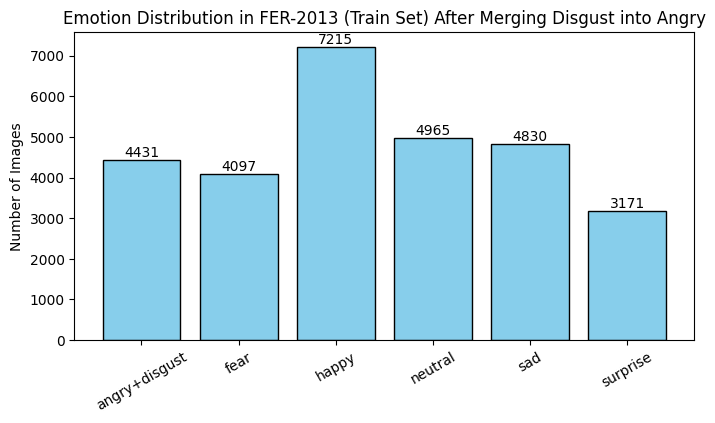

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

# Original labels
train_labels = [label for _, label in train_data.samples]

# Get class names
class_names = train_data.classes

# Map old labels to new labels
# Let's say 'angry' was 0, 'disgust' was 1 originally
# New mapping: angry+disgust -> 0, fear -> 1, happy -> 2, neutral -> 3, sad -> 4, surprise -> 5
label_map = {class_names.index('angry'): 0,
             class_names.index('disgust'): 0,
             class_names.index('fear'): 1,
             class_names.index('happy'): 2,
             class_names.index('neutral'): 3,
             class_names.index('sad'): 4,
             class_names.index('surprise'): 5}

# Apply mapping
new_labels = [label_map[label] for label in train_labels]

# New class names
new_class_names = ['angry+disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Count new labels
label_counts = Counter(new_labels)

# Plot
plt.figure(figsize=(8,4))
bars = plt.bar(new_class_names, [label_counts[i] for i in range(len(new_class_names))], 
               color='skyblue', edgecolor='black')
plt.title("Emotion Distribution in FER-2013 (Train Set) After Merging Disgust into Angry")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)

# Add counts on top of bars
for bar, count in zip(bars, [label_counts[i] for i in range(len(new_class_names))]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=10)
plt.show()


In [13]:
# Update labels in the training dataset
for i, (path, label) in enumerate(train_data.samples):
    train_data.samples[i] = (path, label_map[label])
train_data.targets = [label_map[label] for label in train_data.targets]

# Update labels in the test dataset
for i, (path, label) in enumerate(test_data.samples):
    test_data.samples[i] = (path, label_map[label])
test_data.targets = [label_map[label] for label in test_data.targets]

print("Train labels after mapping:", set(train_data.targets))
print("Test labels after mapping:", set(test_data.targets))


Train labels after mapping: {0, 1, 2, 3, 4, 5}
Test labels after mapping: {0, 1, 2, 3, 4, 5}


In [14]:
from torch.utils.data import DataLoader, random_split

val_size = int(0.15 * len(train_data))
train_size = len(train_data) - val_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_data))


Train: 24403
Val: 4306
Test: 7178


**CNN Model**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        dummy_input = torch.zeros(1,1,48,48)
        x = self.conv_layers(dummy_input)
        flatten_size = x.numel()
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EmotionCNN(num_classes=6).to(device)
print(model)


EmotionCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training Loop**

In [17]:
num_epochs = 20

for epoch in range(num_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/20] Train Loss: 1.6946, Train Acc: 28.68% | Val Loss: 1.5752, Val Acc: 34.97%
Epoch [2/20] Train Loss: 1.5199, Train Acc: 39.14% | Val Loss: 1.4446, Val Acc: 43.33%
Epoch [3/20] Train Loss: 1.4345, Train Acc: 43.13% | Val Loss: 1.3572, Val Acc: 45.96%
Epoch [4/20] Train Loss: 1.3594, Train Acc: 46.18% | Val Loss: 1.3141, Val Acc: 48.58%
Epoch [5/20] Train Loss: 1.3167, Train Acc: 48.45% | Val Loss: 1.2606, Val Acc: 50.49%
Epoch [6/20] Train Loss: 1.2778, Train Acc: 50.40% | Val Loss: 1.2337, Val Acc: 52.32%
Epoch [7/20] Train Loss: 1.2516, Train Acc: 51.28% | Val Loss: 1.2000, Val Acc: 53.95%
Epoch [8/20] Train Loss: 1.2184, Train Acc: 52.85% | Val Loss: 1.1954, Val Acc: 54.60%
Epoch [9/20] Train Loss: 1.2030, Train Acc: 53.36% | Val Loss: 1.1743, Val Acc: 54.53%
Epoch [10/20] Train Loss: 1.1872, Train Acc: 53.79% | Val Loss: 1.1738, Val Acc: 54.48%
Epoch [11/20] Train Loss: 1.1726, Train Acc: 54.81% | Val Loss: 1.1663, Val Acc: 55.23%
Epoch [12/20] Train Loss: 1.1568, Train A

**Testing Accuracy**

Test Accuracy: 54.39%


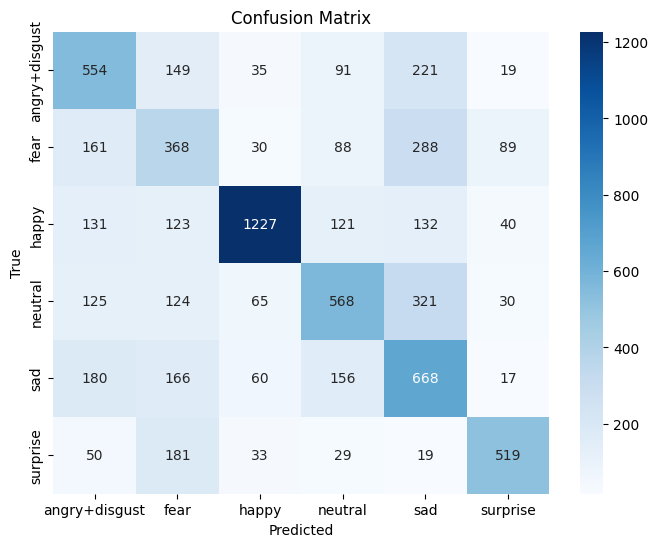

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Test accuracy
test_acc = 100 * sum([a==b for a,b in zip(all_labels, all_preds)]) / len(all_labels)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute metrics properly
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=new_class_names))


Accuracy: 0.5438840902758428
Precision: 0.5516863738975385
Recall: 0.5316955075622919
F1 Score: 0.5373518614900917

Classification Report:
               precision    recall  f1-score   support

angry+disgust       0.46      0.52      0.49      1069
         fear       0.33      0.36      0.34      1024
        happy       0.85      0.69      0.76      1774
      neutral       0.54      0.46      0.50      1233
          sad       0.41      0.54      0.46      1247
     surprise       0.73      0.62      0.67       831

     accuracy                           0.54      7178
    macro avg       0.55      0.53      0.54      7178
 weighted avg       0.57      0.54      0.55      7178



In [20]:
import os

output_dir = "/kaggle/working/cnn_results"
os.makedirs(output_dir, exist_ok=True)

print("Saving everything in:", output_dir)


Saving everything in: /kaggle/working/cnn_results


In [21]:
model_path = os.path.join(output_dir, "cnn_model.pth")
torch.save(model.state_dict(), model_path)

print("Model saved:", model_path)


Model saved: /kaggle/working/cnn_results/cnn_model.pth


In [22]:
import json

metrics = {
    "test_accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1)
}

metrics_path = os.path.join(output_dir, "cnn_metrics.json")

with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved:", metrics_path)


Metrics saved: /kaggle/working/cnn_results/cnn_metrics.json


In [23]:
report_path = os.path.join(output_dir, "classification_report.txt")

with open(report_path, "w") as f:
    f.write(classification_report(all_labels, all_preds, target_names=new_class_names))

print("Classification report saved:", report_path)


Classification report saved: /kaggle/working/cnn_results/classification_report.txt


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_path = os.path.join(output_dir, "confusion_matrix.png")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()

print("Confusion matrix saved:", cm_path)


Confusion matrix saved: /kaggle/working/cnn_results/confusion_matrix.png
